In [88]:
import numpy as np
import tensorflow as tf
import pylab
%matplotlib inline

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

Dim. of X-data: 400 x 2
Mean p: 
[ 0.4525  0.515   0.4975  0.445   0.5     0.44    0.4825  0.495   0.5075
  0.5675  0.5525  0.5025  0.5025  0.5175  0.4025  0.555   0.5425  0.4575
  0.4525  0.5     0.515   0.555   0.47    0.465   0.5325  0.515   0.4675
  0.5325  0.465   0.465   0.47    0.5325  0.485   0.525   0.525   0.455
  0.485   0.4875  0.5075  0.5     0.49    0.5275  0.465   0.5225  0.4475
  0.485   0.4875  0.555   0.4575  0.49    0.485   0.5275  0.48    0.51
  0.55    0.5375  0.4925  0.5025  0.475   0.485   0.4725  0.51    0.465
  0.5025  0.5125  0.47    0.5325  0.485   0.465   0.4975  0.47    0.535
  0.5125  0.5525  0.515   0.52    0.4875  0.515   0.5025  0.455   0.5425
  0.43    0.51    0.5425  0.475   0.5475  0.53    0.4675  0.5025  0.52
  0.51    0.475   0.53    0.52    0.5275  0.4725  0.4475  0.5025  0.475
  0.5275]
Dim. of Y-data: 400 x 100
Assumed f-mean:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

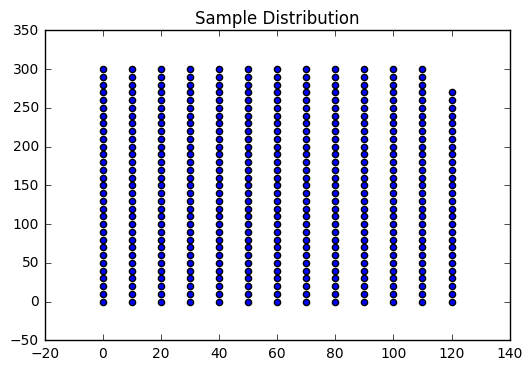

In [89]:
nr_inds=400  # Nr. of Individuals to Check
X_data = np.loadtxt('./coordinates1.csv', delimiter='$').astype('float64')[:nr_inds,:] # Only load first nr_inds entries
#X_data /= np.max(X_data)    # Divide by the maximum WHY??
Y_data = np.loadtxt('./data_genotypes1.csv', delimiter='$').astype('float64')[:nr_inds,:]



#print(mean_f)

#./data_genotypes5.csv has mean p=0.2

assert(len(X_data) == len(Y_data))

N = X_data.shape[0]
k = X_data.shape[1]
print("Dim. of X-data: %i x %i" % (N,k))
M1 = Y_data.shape[0]
nr_loci = Y_data.shape[1]


p_mean=np.mean(Y_data, axis=0) # Empirical average for every loci
#p_mean=np.mean(Y_data)
print("Mean p: ")
print(p_mean)

# Change this for coordinates5.csv  (If mean is known)
#f_mean = np.loadtxt('./mean_f6.csv', delimiter='$').astype('float64')   # Empirical f_mean
#f_mean = np.log(p_mean) - np.log(1 - p_mean) # Does a Logit Transform
#f_mean=np.log(0.2)-np.log(1.0-0.2)   # If known

#print(len(f_mean))
#print(len(f_mean))
Y_data[Y_data < 0.5] = -1.0
print("Dim. of Y-data: %i x %i" % (M1, nr_loci))

#mean_paramss = np.array([f_mean for _ in range(nr_loci)]) # Initial Parameter for the mean-parameters
mean_paramss = np.array([0.0 for _ in range(nr_loci)])  # Set everything to 0
#mean_paramss = np.array(f_mean)
print("Assumed f-mean:")
print(mean_paramss)

# Plot the data
pylab.figure()
pylab.title("Sample Distribution")
pylab.scatter(X_data[:,0], X_data[:,1])
pylab.show()

In [90]:
def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))
    
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def py_logdet(x, name=None):
    
    with ops.op_scope([x], name, "Logdet") as name:
        logdet = py_func(lambda x: np.linalg.slogdet(x)[1],
                         [x],
                         [tf.float64],
                         name=name,
                         grad=_LogdetGrad)  # <-- here's the call to the gradient
    return logdet[0]

def _LogdetGrad(op, grad):
    x = op.inputs[0]
    return tf.matrix_inverse(x) * grad[:, None, None]

In [91]:
with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value = X_data, trainable=False)
    Y = tf.Variable(dtype=tf.float64, initial_value = Y_data, trainable=False)
    F = tf.Variable(dtype=tf.float64, initial_value = np.random.normal(0.0, 0.1, (N, nr_loci)).astype('float64'),
                    trainable=True)

    kernel_params = tf.placeholder(shape=[2], dtype=tf.float64)      # HyperParameters for the Kernel
    mean_params = tf.placeholder(shape=[nr_loci], dtype=tf.float64)  # HyperParameters for the mean Values
    
    l = tf.abs(kernel_params[1])
    a = tf.abs(kernel_params[0])
    mean_param = mean_params
    
    eye = tf.eye(N)

    K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l **2), reduction_indices=[2])) + \
        0.00001 * tf.eye(N, dtype=tf.float64) # Calculate Matrix of Covariances
    
    #K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l), reduction_indices=[2])) + \
       # 0.0001 * eye                

    f_tot = F + mean_param[None, :]    # Adds mean term; None is at position of an individual
    #f_tot= F + f_mean[None,:]          # Adds empirical mean term
    #f_tot = F + f_mean                 # For the case that there is a single Value
    p = tf.nn.sigmoid(f_tot)            # Calculate probabilities(assuming sigmoid link function)
    Kinv_F = tf.matrix_solve(K, F)      # Calculate K^(-1)*F
    
    data_fit = -tf.reduce_sum(tf.log(1 + tf.exp(-Y * f_tot)), reduction_indices=[0]) # Calculate Data Fit: Check  
    prior_fit = -0.5 * tf.reduce_sum(F * Kinv_F, reduction_indices=[0])          # Calcualte 1st term of prior probability: Check
    
    logL = tf.reduce_sum(data_fit + prior_fit) # Modulo terms not depending on f: Check
    
    g =  (0.5 * (Y + 1) - p) - Kinv_F # Calculate Matrix for Gradients Check
    
    W = p * (1 - p)        # Calculate first part of Hessia. It is diagonal (but here diagonal in every column)
    lhs = -K[:, :, None] * W[None, :, :] - tf.eye(N, dtype=tf.float64)[:, :, None] # Check (HEADACHE)
    #lhs = -K[:, :, None] * W[None, :, :] - eye[:, :, None] 
    rhs = tf.matmul(K, g)
    
    update = tf.matrix_solve(tf.transpose(lhs, [2, 0, 1]), tf.transpose(rhs, [1, 0])[:, :, None])[:, :, 0]
    update = tf.transpose(update)
    
    opt_op = F.assign(F - update)
    
    #####
    
    B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + tf.eye(N, dtype=tf.float64)[:, :, None]  # Check
    #B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + eye[:, :, None] 
    
    logdet = tf.reduce_sum(py_logdet(tf.transpose(B, [2, 0, 1])))  # Factor of 2??
    
    margL = logL - 0.5 * logdet
    
    ##### Gradients and Hessian #######################3
    
    grad = tf.gradients(margL, kernel_params)
    hessian = tf.hessians(margL, kernel_params)

In [92]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.01

In [93]:
### Optimization Run
kk =  np.array([0.05, 20])


with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(100):
        _, r,  g, h= sess.run([opt_op, margL, grad, hessian], {kernel_params: kk, mean_param: mean_paramss})  
        print(r)
        
        if i < 3:  # First three times just run to optimize f_i
            continue
        
        u = np.matmul(np.linalg.inv(h[0]), g[0]) 
        kk -= u
        print(kk, u)
    
    # Code for calculating empirical Fisher-Information Matrix:
fisher_info = np.matrix(h[0])
stds = np.sqrt(np.diag(-fisher_info.I)) # Calculates the Standard Deviations (Sqrt of Variance)
print("Standard Deviations: ")
print(stds)

-8832758.09974
-27678.3425603
-27678.3426257
-27678.3426257
(array([  0.0528943 ,  20.41725295]), array([-0.0028943 , -0.41725295]))
-27677.1223053
(array([  0.05457292,  20.63058925]), array([-0.00167862, -0.21333629]))
-27675.1581544
(array([  0.05680812,  20.92924058]), array([-0.00223519, -0.29865133]))
-27673.8212619
(array([  0.05879357,  21.17561615]), array([-0.00198545, -0.24637557]))
-27672.3688637
(array([  0.0608697 ,  21.43397724]), array([-0.00207614, -0.25836109]))
-27671.1037226
(array([  0.06286939,  21.67295533]), array([-0.00199969, -0.23897809]))
-27669.8949236
(array([  0.06485125,  21.90689766]), array([-0.00198185, -0.23394233]))
-27668.8014539
(array([  0.06677432,  22.1284163 ]), array([-0.00192307, -0.22151864]))
-27667.7981252
(array([  0.06864293,  22.34071061]), array([-0.00186861, -0.21229431]))
-27666.8940667
(array([  0.07044258,  22.54202308]), array([-0.00179965, -0.20131246]))
-27666.0813107
(array([  0.07216871,  22.73313632]), array([-0.00172613, -0

In [95]:
kk

array([  0.08943738,  26.10249871])

In [82]:
a_list = np.logspace(-1.5, -0.5, 10)   # Original Values
l_list = np.logspace(1, 2, 10)

#a_list = np.logspace(-3, -0.5, 10)
#l_list = np.logspace(0, 2, 10)


print(a_list)
print(l_list)
print(len(mean_paramss))

[ 0.03162278  0.04084239  0.05274997  0.06812921  0.08799225  0.11364637
  0.14677993  0.18957357  0.24484367  0.31622777]
[  10.           12.91549665   16.68100537   21.5443469    27.82559402
   35.93813664   46.41588834   59.94842503   77.42636827  100.        ]
100


In [94]:
res = []
j=0
with tf.Session(config=config) as sess:
    for aa in a_list:
        for ll in l_list:
            print("Doing run: %i" % j)
            j+=1
    
            sess.run(tf.global_variables_initializer())   # Changed to global_variables_initializer

            prev = None
            for i in range(20):
                r = sess.run([opt_op, update, logL, margL], {a: aa, l:ll, mean_param: mean_paramss})
                if prev and np.abs(prev - r[-1]) < 0.01:
                    break
                prev = r[-1]
            print("Tested a: %4f" % aa)
            print("Tested l: %4f" % ll)
            print("Likelihood: %4f" % r[-1])
            res.append(r[-1])

Doing run: 0
Tested a: 0.031623
Tested l: 10.000000
Likelihood: -27712.840735
Doing run: 1
Tested a: 0.031623
Tested l: 12.915497
Likelihood: -27705.477158
Doing run: 2
Tested a: 0.031623
Tested l: 16.681005
Likelihood: -27696.862019
Doing run: 3
Tested a: 0.031623
Tested l: 21.544347
Likelihood: -27688.272262
Doing run: 4
Tested a: 0.031623
Tested l: 27.825594
Likelihood: -27681.595210
Doing run: 5
Tested a: 0.031623
Tested l: 35.938137
Likelihood: -27678.921738
Doing run: 6
Tested a: 0.031623
Tested l: 46.415888
Likelihood: -27681.145746
Doing run: 7
Tested a: 0.031623
Tested l: 59.948425
Likelihood: -27687.312024
Doing run: 8
Tested a: 0.031623
Tested l: 77.426368
Likelihood: -27695.552771
Doing run: 9
Tested a: 0.031623
Tested l: 100.000000
Likelihood: -27704.037505
Doing run: 10
Tested a: 0.040842
Tested l: 10.000000
Likelihood: -27709.886403
Doing run: 11
Tested a: 0.040842
Tested l: 12.915497
Likelihood: -27701.000184
Doing run: 12
Tested a: 0.040842
Tested l: 16.681005
Likeliho

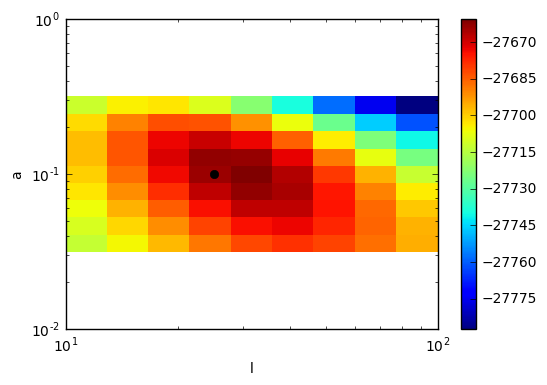

In [96]:
surface = np.array(res).reshape((10, 10))
pylab.pcolormesh(l_list, a_list, surface)
pylab.xscale('log')
pylab.yscale('log')
pylab.xlabel('l')
pylab.ylabel('a')
pylab.colorbar()
pylab.plot(25, 0.1, 'ko', linewidth=5)

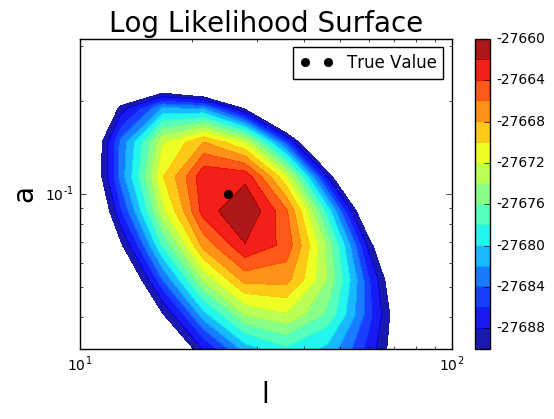

In [97]:
pylab.figure()
levels = np.arange(max(res) - 30, max(res) + 1, 2)  # Every two likelihood units
ax=pylab.contourf(l_list, a_list, surface, alpha=0.9, levels=levels)

# plt.clabel(ax, inline=1, fontsize=10)
pylab.colorbar(ax, format="%i")
pylab.title("Log Likelihood Surface", fontsize=20)
pylab.xlabel("l", fontsize=20)
pylab.ylabel("a", fontsize=20)
pylab.xscale('log')
pylab.yscale('log')
pylab.plot(25, 0.1, 'ko', linewidth=5, label="True Value")
pylab.legend()
pylab.show()

In [85]:
aa, ll = 0.1, 25
kk = np.array([0.1, 25])

In [87]:
# Single Run; where optimization is computed.
with tf.Session(config=config) as sess:
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())   # Update by Harald
    
    for i in range(5):
        sess.run(opt_op, {kernel_params: kk, mean_param: mean_paramss})
    r = sess.run([F, margL], {kernel_params: kk, mean_param: mean_paramss})
    print(r[-1])   # Prints the Marginal Likelihood
print(r[0])
print(np.max(r[0])) # Calculates Maximum and Minimum of estimated F-Values
print(np.min(r[0]))

-6914.353692
[[-0.17997477 -0.05951553 -0.22558973 ..., -0.13693168 -0.00167064
  -0.00514589]
 [-0.18832692 -0.0825822  -0.29664615 ..., -0.14003488 -0.01921005
  -0.01170005]
 [-0.17332261 -0.07347112 -0.33900452 ..., -0.12412402 -0.04330111
  -0.01964239]
 ..., 
 [-0.10067399  0.04347572 -0.29803511 ..., -0.15990841 -0.15758894
  -0.13195411]
 [ 0.0023042   0.12736939 -0.24926496 ..., -0.14834468 -0.12657619
  -0.11826243]
 [ 0.10881546  0.19547715 -0.20817105 ..., -0.14246627 -0.09159498
  -0.09087524]]
0.400827055188
-0.474344356071


In [ ]:
x, y, z = X_data[:nr_inds, 0], X_data[:nr_inds, 1], r[0][:,1]
#x=np.linspace(0, 1, 20)
#print(len(x))
print(len(x))
print(len(y))
print(len(z))

In [ ]:
pylab.pcolormesh(x, y, z.reshape(21,21))
pylab.colorbar()

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
z.shape

In [ ]:
961 ** 0.5

In [ ]:
with tf.Session() as sess:
    r = sess.run(tf.diag(tf.ones(5)))

In [ ]:
r

In [ ]:
tf.__version__

In [ ]:
logdet

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    r = sess.run(logdet, {a: 1.0, l: 1.0})

In [ ]:
r